# Prepare Census Block OD Data

In [2]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
import json
import requests
import pickle

import src.bikewaysim_functions as bikewaysim_functions

import sys
sys.path.insert(0,str(Path.cwd().parent))
import file_structure_setup
config = file_structure_setup.filepaths()

# Retrieve LODES7 data

In [3]:
state_two_letter = "ga"
YYYY = 2010
lodes_url_base = f"https://lehd.ces.census.gov/data/lodes/LODES7/{state_two_letter}/od/{state_two_letter}_od_main_JT00_{YYYY}.csv.gz"
lodes = pd.read_csv(lodes_url_base)

#processs df
rename_dict = {
    'w_geocode':'work_blockid',
    'h_geocode':'home_blockid',
    'S000': 'total_jobs'  
}
lodes.rename(columns=rename_dict, inplace=True)
lodes = lodes[['work_blockid','home_blockid','total_jobs']]


# Census Blocks

In [4]:
#study area for masking blocks
studyarea = gpd.read_file(config['studyarea_fp'])#.to_crs(config['projected_crs_epsg'])
studyarea = studyarea.unary_union.envelope

In [5]:
#bring in census blocks (get from https://www.census.gov/cgi-bin/geo/shapefiles/index.php)
#TODO script downloading the blocks
blocks = gpd.read_file("/Users/tannerpassmore/Documents/BikewaySim/Savannah/OD Creation/tl_2010_13_tabblock10.shp",mask=studyarea).to_crs(config['projected_crs_epsg'])
blocks.rename(columns={'GEOID10':'blockid'},inplace=True)
blocks = blocks[['blockid','geometry']]

# Data Wrangling

In [6]:
#make sure type are the same
lodes['work_blockid'] = lodes['work_blockid'].astype(int)
lodes['home_blockid'] = lodes['home_blockid'].astype(int)
blocks['blockid'] = blocks['blockid'].astype(int)

In [7]:
#filter lodes data
print('lodes:',lodes.shape[0],'blocks:',blocks.shape[0])
lodes = lodes[lodes['work_blockid'].isin(blocks['blockid']) & lodes['home_blockid'].isin(blocks['blockid'])]
blocks = blocks[blocks['blockid'].isin(lodes['work_blockid']) | blocks['blockid'].isin(lodes['home_blockid'])]
print('lodes:',lodes.shape[0],'blocks:',blocks.shape[0])

lodes: 3196531 blocks: 8640
lodes: 71265 blocks: 5140


Only 3 mile trips

In [8]:
block_geo = dict(zip(blocks['blockid'],blocks['geometry'].centroid))
home = gpd.GeoSeries(lodes['home_blockid'].map(block_geo),crs=blocks.crs)
work = gpd.GeoSeries(lodes['work_blockid'].map(block_geo),crs=blocks.crs)
lodes = lodes[home.distance(work) <= 3 * 5280]

In [9]:
#rename to make it easier to work with teh code for tazs
#assume home is the origin
lodes.columns = ['dest_taz','orig_taz','trips']
blocks.columns = ['tazid','geometry']

# Snap to network

In [10]:
# import network nodes
nodes = gpd.read_file(config['network_fp']/"final_network.gpkg",layer="nodes")

with (config['calibration_fp']/"calibration_network.pkl").open('rb') as fh:
    links,turns = pickle.load(fh)
del turns

nodes0 = links['A'].append(links['B'])
nodes = nodes[nodes['N'].isin(nodes0)]

/var/folders/66/68r0k8s534v4gf9flsfnxnsr0000gn/T/ipykernel_4082/2413887731.py:8: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nodes0 = links['A'].append(links['B'])


In [11]:
blocks = bikewaysim_functions.snap_ods_to_network(blocks,nodes)

#knock out if over 1000 feet
blocks = blocks[blocks['dist']<=500]

In [12]:
snapped_ods = dict(zip(blocks['tazid'],blocks['N']))
lodes['orig_N'] = lodes['orig_taz'].map(snapped_ods)
lodes['dest_N'] = lodes['dest_taz'].map(snapped_ods)

In [13]:
lodes.dropna(inplace=True)

In [14]:
trip_origins_per_taz = lodes.groupby('orig_taz')['trips'].sum().reset_index()
trip_origins_per_taz.columns = ['tazid','trip_origins']

In [15]:
# no trips
no_trips = blocks[blocks['tazid'].isin(trip_origins_per_taz['tazid'])==False]
no_trips

,tazid,geometry,N,dist
8,130299203051048,"POLYGON ((924076.267 714687.008, 923659.531 71...",9736791851,341.448365
89,130299203051046,"POLYGON ((922405.218 711398.390, 922519.073 71...",7043179808,473.338498
292,130510107001011,"POLYGON ((956846.142 814724.090, 957250.393 81...",7121913821,134.657264
293,130510107001333,"POLYGON ((963674.415 774060.936, 963712.464 77...",7145108741,393.557860
294,130510107001332,"POLYGON ((965142.334 772786.191, 964958.141 77...",7043486419,265.257549
...,...,...,...,...
4872,130510111043005,"POLYGON ((1023527.623 734639.328, 1023398.036 ...",7037948160,96.933749
4874,130510111062003,"POLYGON ((1014486.901 745048.383, 1014505.173 ...",7044041576,302.139345
4875,130510111032032,"POLYGON ((1064910.788 731024.981, 1065084.134 ...",8341193998,120.971893
4876,130510111062007,"POLYGON ((1013146.405 743843.929, 1012898.541 ...",8596723941,57.215628


In [16]:
blocks = blocks.merge(trip_origins_per_taz,on='tazid')

In [30]:
blocks.to_file(config['bikewaysim_fp']/'ods.gpkg',layer='trip_origins')

In [17]:
# trip origins per TAZ
#export the taz areas
blocks.to_crs(config['projected_crs_epsg']).to_file(config['bikewaysim_fp']/'map_layers.gpkg',layer='taz_polygons')
#export the taz centroids
taz_centroids = blocks.copy().to_crs(config['projected_crs_epsg'])
taz_centroids.geometry = taz_centroids.geometry.centroid
taz_centroids.to_crs(config['projected_crs_epsg']).to_file(config['bikewaysim_fp']/'map_layers.gpkg',layer='taz_centroids')

<Axes: >

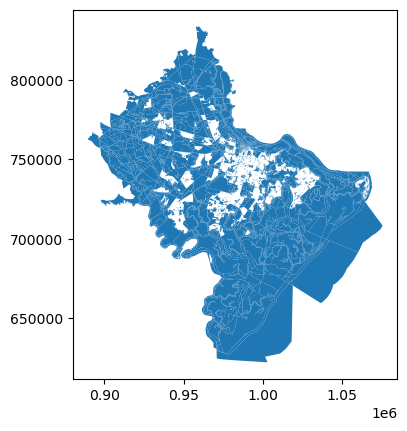

In [28]:
studyarea = gpd.read_file(config['studyarea_fp'])
blocks0 = gpd.read_file("/Users/tannerpassmore/Documents/BikewaySim/Savannah/OD Creation/tl_2010_13_tabblock10.shp",mask=studyarea).to_crs(config['projected_crs_epsg'])
blocks0.rename(columns={'GEOID10':'tazid'},inplace=True)
blocks0['tazid'] = blocks0['tazid'].astype(int)
blocks0 = blocks0[['tazid','geometry']]
blocks0 = blocks0[blocks0['tazid'].isin(blocks['tazid'])==False]
blocks0.plot()

In [29]:
blocks0.to_file(config['bikewaysim_fp']/'ods.gpkg',layer='filtered_out_or_zero')

# Export

In [118]:
print(lodes['trips'].sum(),'trips across',lodes.shape[0],'unique OD pairs')#,tripData['hh_id'].nunique(),'persons')
print('and',blocks.shape[0],'census blocks')

17856 trips across 15275 unique OD pairs
and 2921 census blocks


In [119]:
# #export the taz areas
# blocks.to_file(config['bikewaysim_fp']/'map_layers.gpkg',layer='block_polygons')

# #export the taz centroids
# blocks_centroids = blocks.copy()
# blocks_centroids.geometry = blocks_centroids.geometry.centroid
# blocks_centroids.to_crs(config['projected_crs_epsg']).to_file(config['bikewaysim_fp']/'map_layers.gpkg',layer='block_centroids')

#export the ods
lodes.to_csv(config['bikewaysim_fp']/'od_matrix.csv',index=False)

Exploring past here

In [120]:
lodes

,dest_taz,orig_taz,trips,orig_N,dest_N
239231,130510001001004,130510011002033,1,8.918424e+09,8.092881e+09
239232,130510001001004,130510027004012,1,5.432307e+09,8.092881e+09
239233,130510001001004,130510028001005,1,6.714626e+07,8.092881e+09
239241,130510001001004,130510114002000,1,6.714431e+07,8.092881e+09
239242,130510001001004,130510116002009,1,6.708073e+07,8.092881e+09
...,...,...,...,...,...
342431,130519800001057,130510116001016,1,7.860268e+09,8.080005e+09
342432,130519800001057,130510116001018,1,8.879344e+09,8.080005e+09
342433,130519800001057,130510116001028,1,7.622715e+09,8.080005e+09
342660,130519800001058,130510033012006,1,6.710322e+07,7.257544e+09


In [121]:
# works = lodes[['work_blockid','total_jobs']].copy()
# works = works.groupby('work_blockid')['total_jobs'].sum().reset_index()
# works = pd.merge(works,blocks[['blockid','geometry']],left_on="work_blockid",right_on='blockid')
# works = gpd.GeoDataFrame(works,geometry='geometry')
# works.explore('total_jobs')
# merged = pd.merge(lodes,blocks[['blockid','geometry']],left_on="work_blockid",right_on='blockid',how='left')
# merged.drop(columns=['blockid'],inplace=True)
# merged.rename(columns={'geometry':'work_geo'},inplace=True)
# merged = pd.merge(merged,blocks[['blockid','geometry']],left_on="home_blockid",right_on='blockid',how='left')
# merged.drop(columns=['blockid'],inplace=True)
# merged.rename(columns={'geometry':'home_geo'},inplace=True)
# merged = merged[merged['home_geo'].notna() & merged['work_geo'].notna()]
# random_id = merged['work_blockid'].sample(1).item()
# subset = merged.loc[merged['work_blockid']==random_id].copy()
# subset = gpd.GeoDataFrame(subset,geometry='home_geo')
# m = subset.explore()
# blocks.loc[blocks['blockid']==random_id,'geometry'].explore()
# work = blocks.loc[blocks['blockid']==random_id,'geometry'].to_crs('epsg:4326').item().centroid
# x, y = list(work.coords)[0]
# import folium
# folium.Circle((y,x),radius=100,tooltip='WORK',kwargs={'color':'green'}).add_to(m)
# m
# merged['work_geo'] = gpd.GeoSeries(merged['work_geo']).centroid
# merged['home_geo'] = gpd.GeoSeries(merged['home_geo']).centroid
# # import geopandas as gpd
# # import pandas as pd
# # from pathlib import Path
# # import json

# # config = json.load((Path.cwd().parent / 'config.json').open('rb'))
# # network_fp = Path(config['project_directory']) / "Network"
# # osmdwnld_fp = Path(config['project_directory']) / "OSM_Download"
# # elevation_fp = Path(config['project_directory']) / "Elevation"
# # cyclinginfra_fp = Path(config['project_directory']) / "Cycling_Infra_Dating"
# # calibration_fp = Path(config['project_directory']) / "Calibration"



# #'foot' in blocks.crs.axis_info[0].unit_name

# #df.crs.axis_info[0].unit_name